# Notebook to train the deep learning model on the ECoG dataset

In [16]:
from DL_utils import *
from Dataset import ECoG_Dataset
from torch.utils.data import DataLoader
from tests import *
from Models import LeNet5
from torch.optim.adam import Adam
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error

Set the data directory, sampling rate and additional required folder

In [17]:
data_dir = 'C:\\Users\\anellim1\Develop\Econ\BCICIV_4_mat\\'
file_name = 'sub1_comp.mat'
sampling_rate = 1000

figure_path = '..\Figures'
model_path = '..\Models'

In [18]:
# Set skip_training to False if the model has to be trained, to True if the model has to be loaded.
skip_training = True

In [19]:
# Set the torch device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device = {}'.format(device))

Device = cpu


Initialize the datasets.

In [20]:
trainset = ECoG_Dataset(data_dir, file_name, True, 0, 0.5, 1000)
testset = ECoG_Dataset(data_dir, file_name, False, 0, 0.5, 1000)

print('Trainset dim: {}, Testset dim: {}'.format(trainset.__len__(), testset.__len__()))

torch.Size([62, 400000])
window 500, stride 250, x.shape torch.Size([62, 400000])
torch.Size([1, 400000])
window 500, stride 250, x.shape torch.Size([1, 400000])
The input data are of shape: torch.Size([1599, 62, 500]), the corresponding y shape (filtered to 1 finger) is: torch.Size([1599])
torch.Size([62, 400000])
window 500, stride 250, x.shape torch.Size([62, 400000])
torch.Size([1, 400000])
window 500, stride 250, x.shape torch.Size([1, 400000])
The input data are of shape: torch.Size([1599, 62, 500]), the corresponding y shape (filtered to 1 finger) is: torch.Size([1599])
Trainset dim: 959, Testset dim: 640


Initialize the dataloaders.

In [21]:
trainloader = DataLoader(trainset, batch_size=50, shuffle=False, num_workers=1)
testloader = DataLoader(trainset, batch_size=5, shuffle=False, num_workers=1)

In [22]:
# Test the network architecture
sample, _ = iter(trainloader).next()
test_LeNet5_shape(sample, device)

Shape of the input tensor: torch.Size([50, 62, 500])
Test LeNet5 output shape: Success.


Initialize network and training loop.

In [23]:
net = LeNet5()
net = net.to(device)

In [24]:
# Training loop or model loading
if not skip_training:
    print('Begin training...')
    EPOCHS = 200
    optimizer = Adam(net.parameters(), lr=0.001)
    net.train()
    loss_function = torch.nn.MSELoss()

    for epoch in tqdm(range(1, EPOCHS+1)):
        losses = []
        for data, labels in trainloader:
            # Set data to appropiate device
            data, labels = data.to(device), labels.to(device)
            # Clear the gradients
            optimizer.zero_grad()
            # Fit the network
            out = net(data)
            #Loss function
            loss = loss_function(out, labels)
            losses.append(loss.item())
            # Backpropagation and weights update
            loss.backward()
            optimizer.step()

        print('Epoch: {}/{}. loss = {:.4f}'.format(epoch, EPOCHS, np.mean(losses)))

if not skip_training:
    # Save the trained model
    save_pytorch_model(net, model_path, 'Baselinemodel_lenet5.pth')
else:
    # Load the model
    net = LeNet5()
    net = load_pytorch_model(net, os.path.join(model_path,'Baselinemodel_lenet5.pth'), 'cpu')

Model loaded from ..\Models\Baselinemodel_lenet5.pth.


Evaluate the model.

In [25]:
# Evaluation
print("Evaluation...")
net.eval()
y_pred = []
y = []
with torch.no_grad():
    for data, labels in testloader:
        y.extend(list(labels))
        y_pred.extend((list(net(data))))

Evaluation...


In [26]:
# Calculate Evaluation measures
print('mean squared error {}'.format(mean_squared_error(y, y_pred)))
print('mean absolute error {}'.format(mean_absolute_error(y, y_pred)))

mean squared error 0.07978563755750656
mean absolute error 0.2282094955444336


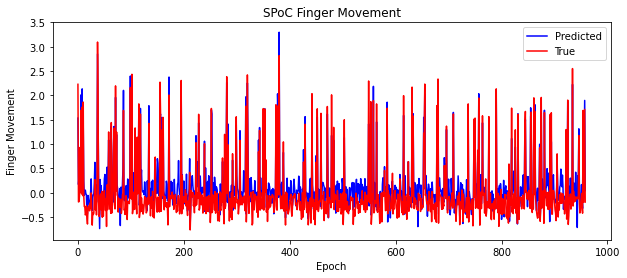

In [27]:
# plot y_new against the true value
fig, ax = plt.subplots(1, 1, figsize=[10, 4])
times = np.arange(len(y_pred))
ax.plot(times, y_pred, color='b', label='Predicted')
ax.plot(times, y, color='r', label='True')
ax.set_xlabel('Epoch')
ax.set_ylabel('Finger Movement')
ax.set_title('SPoC Finger Movement')
plt.legend()
plt.savefig(os.path.join(figure_path, 'SPoC_Finger_Prediction.pdf'))
plt.show()